In [8]:
import matplotlib.pyplot as plt
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'r.', markersize=12)
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)

    ax.set_title(title)

### Implement GP with sklearn
The squared exponential kernel is the `RBF` kernel and it only has a `length_scale` parameter corresponding to the $l$ parameter above. To have a $\sigma_f$ parameter as well, it needs `ConstantKernel`.

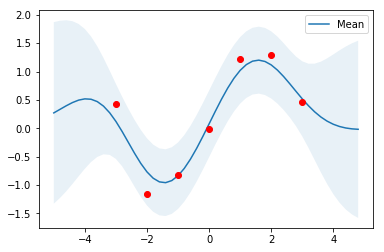

In [9]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=noise**2)

# Reuse training data from previous 1D example
gpr.fit(X_train, Y_train)

# Compute posterior predictive mean and covariance with new data(X)
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
mu_s, cov_s = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# Compare with previous results
# assert(np.isclose(l_opt, l))
# assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

### Implement GP with GPy

`GPRegression` can estimate the noise parameter $\sigma_y$ from data, so we have to `fix()` this parameter to be able to reproduce the above results.

In [10]:
import GPy

rbf = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
gpr = GPy.models.GPRegression(X_train, Y_train, rbf)

# Fix the noise variance to known value 
gpr.Gaussian_noise.variance = noise**2
gpr.Gaussian_noise.variance.fix()

# Run optimization
gpr.optimize();

# Display optimized parameter values
display(gpr)

GP_regression.,value,constraints,priors
rbf.variance,0.7169035244218407,+ve,
rbf.lengthscale,1.222254211802542,+ve,
Gaussian_noise.variance,0.16000000000000003,+ve fixed,


 /home/wonchul/.virtualenvs/p3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


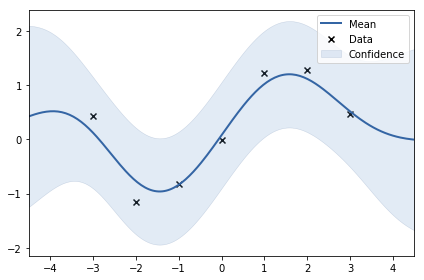

In [12]:
# Obtain optimized kernel parameters
l = gpr.rbf.lengthscale.values[0]
sigma_f = np.sqrt(gpr.rbf.variance.values[0])

# Compare with previous results
# assert(np.isclose(l_opt, l))
# assert(np.isclose(sigma_f_opt, sigma_f))

# Plot the results with the built-in plot function
gpr.plot();